In [1]:
import pandas as pd
import numpy as np
from gravity_utils import *

In [70]:
pd.set_option('display.max_rows', 1398)

In [2]:
import shapefile
import shapely.wkt

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
import stat
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, log_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor

In [4]:
a2 = read_shapefile('data/GIS/A2_samsSW_2012_shp/A2_sw_region.shp')
a2['KOMMUN'] = a2.KOMMUN.astype(int)
a2['SAMSCODE'] = a2.SAMSCODE.astype(int)
night_pop = a2[(a2.KOMMUN > 1200) & (a2.KOMMUN < 1300)]
target_night_pop = night_pop.loc[(night_pop.KOMMUN == 1265) | (night_pop.KOMMUN == 1270)]
target_night_pop = target_night_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']
other_night_pop = night_pop.loc[(night_pop.KOMMUN != 1265) & (night_pop.KOMMUN != 1270)]
other_night_pop = other_night_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']

a4 = read_shapefile('data/GIS/A4_samsSW_2012_shp/A4_sw_region.shp')
a4['KOMMUN'] = a4.KOMMUN.astype(int)
a4['SAMSCODE'] = a4.SAMSCODE.astype(int)
a4 = a4[(a4.KOMMUN > 1200) & (a4.KOMMUN < 1300)]
target_day_pop = a4.loc[(a4.KOMMUN == 1265) | (a4.KOMMUN == 1270)]
target_day_pop = target_day_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']
other_day_pop = a4.loc[(a4.KOMMUN != 1265) & (a4.KOMMUN != 1270)]
other_day_pop = other_day_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']

sams_w_nbuildings = pd.read_csv('data/GIS/B1_samsSW_20131231_shp/B1_sams_with_nbuildings.csv', sep=';', index_col=0)
sams_w_nbuildings['SAMSCODE'] = sams_w_nbuildings.SAMSCODE.astype(int)
sams_w_nbuildings['KOMMUN'] = sams_w_nbuildings.KOMMUN.astype(int)

target_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN == 1265) | (sams_w_nbuildings.KOMMUN == 1270)]
target_buildings = target_buildings.groupby(['SAMSCODE']).sum()
other_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN != 1265) & (sams_w_nbuildings.KOMMUN != 1270)]
other_buildings = other_buildings.groupby(['KOMMUN']).sum()

#buildings = sams_w_nbuildings.groupby(['SAMSCODE'])['nProduction', 'nAttraction','TotBef', 'small_building', 'appt_build', 'multi_appartment_building'].sum()

In [6]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
upsampled_resfil = draw_population(resfil_raw, resfil_raw.individvikt.astype(int))
upsampled_resfil = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1)] 
#                                     (upsampled_resfil['rf4_komkod'] < 2000) &
#                                     (upsampled_resfil['rf4_komkod'] > 100) &
#                                     (upsampled_resfil['rf1_komkod'] < 2000) &
#                                     (upsampled_resfil['rf1_komkod'] > 100)
#                                    ]
attraction_rvu = upsampled_resfil[(upsampled_resfil['rf4_komkod'] < 2000) &
                                    (upsampled_resfil['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
production_rvu = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

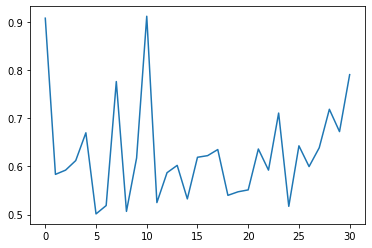

In [7]:
plt.plot(pd.concat([production_rvu, other_night_pop.TotaltA2, production_rvu/other_night_pop.TotaltA2], axis=1).sort_values(['TotaltA2'])[0].values)

In [95]:
production_raw_rvu = resfil_raw[(resfil_raw['ärende_2'] == 1) &
                                (resfil_raw['rf1_komkod'] < 2000) &
                                (resfil_raw['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()

rvu_vs_scb = pd.DataFrame([production_raw_rvu, sams_w_nbuildings.set_index('SAMSCODE').TotBef, production_raw_rvu / sams_w_nbuildings.set_index('SAMSCODE').TotBef], 
             index=['rvu', 'sams', 'ratio']).T.sort_values(['ratio'], ascending=False)

In [96]:
sams_ids = rvu_vs_scb[(rvu_vs_scb['ratio'] < 10) & (rvu_vs_scb['ratio'] > 0.03) & (rvu_vs_scb['rvu'] > 5)]
sams_index = sams_ids.index
sams_ids

,rvu,sams,ratio
12810036.0,8.0,3.0,2.666667
12810083.0,33.0,563.0,0.058615
12620018.0,13.0,238.0,0.054622
12810019.0,31.0,582.0,0.053265
12840025.0,99.0,1872.0,0.052885
12840031.0,98.0,1926.0,0.050883
12620019.0,6.0,122.0,0.049180
12850030.0,18.0,384.0,0.046875
12620020.0,19.0,442.0,0.042986
12810109.0,6.0,142.0,0.042254


In [101]:
production_sams_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
production_kommun_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

In [102]:
target_x_sams = pd.concat([target_night_pop, target_buildings, target_day_pop], axis=1)
other_x_sams = pd.concat([other_night_pop, other_buildings, other_day_pop], axis=1)

all_x_sams = pd.concat([target_x_sams, other_x_sams])

# all_y_prod = pd.concat([target_night_pop, other_night_pop])
# all_y_att = pd.concat([target_day_pop, other_day_pop])

kommun_rvu_prod = production_kommun_rvu
sams_rvu_prod = production_sams_rvu.loc[sams_index]

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


# Production linear regression

In [103]:
def print_stats (model, X, y):
    lm = model
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    # newX = pd.DataFrame({"Constant":np.ones(len(X))}, index = X.index).join(pd.DataFrame(X))
    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
    myDF3.index = np.append(['intercept_'], X.columns.values)
    print(myDF3)

In [287]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

x_prod = other_x_sams.drop(axis=1, labels=['Ald20_24','TotBef','Ald65_W','Ald7_15','multi_appartment_building','nEkonomi','nIndustri','nProduction','appt_build','nAttraction','Ald16_19','Ald0_6','SAMSCODE', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'TotaltA4', 'OffentligaA4', 'NaringslivA4'])
y_prod = other_night_pop.TotaltA2

x_prod = x_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])
y_prod = y_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])

scaler_prod = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_prod.fit(x_prod)

X_prod = pd.DataFrame(scaler_prod.transform(x_prod), columns=x_prod.columns, index=x_prod.index)
production_model = lin.fit(X_prod, y_prod)
train_prod_pred = production_model.predict(X_prod)
score = r2_score(y_prod, train_prod_pred)
print('R**2 value')
print(score)
# print(pd.DataFrame(production_model.coef_, index=X_prod.columns))
print_stats(production_model, X_prod, y_prod)

R**2 value
0.9883588023583453
                Coefficients  Standard Errors  t values  Probabilites
intercept_            0.0000          274.107     0.000         1.000
Ald25_44              1.1646            0.220     5.293         0.000
Ald45_64              0.3798            0.273     1.391         0.177
small_building        0.2596            0.080     3.250         0.003


In [284]:
y_pred = production_model.predict(scaler.transform(target_x_sams.loc[:, X_prod.columns]))
score = r2_score(y_pred, target_x_sams.TotaltA2)
print('R**2 value')
print(score)

R**2 value
0.9920067065005018


In [270]:
pred_prod_sams = pd.DataFrame(y_pred, index=target_x_sams.index, columns=['pred_prod'])
df = pd.concat([pred_prod_sams, target_night_pop.TotaltA2], axis=1)
df['diff'] = df.pred_prod / df.TotaltA2
df.describe()

,pred_prod,TotaltA2,diff
count,37.000000,37.000000,37.000000
mean,396.210475,403.513514,0.952838
std,345.446255,339.654287,0.108138
min,41.763258,58.000000,0.710756
25%,118.827660,128.000000,0.903572
50%,337.316234,349.000000,0.962559
75%,543.784053,528.000000,0.999499
max,1587.448720,1626.000000,1.267699


# Attraction Linear regression

In [266]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

x_att = other_x_sams.drop(axis=1, labels=['TotBef','Ald20_24','appt_build','nEkonomi','small_building','nAttraction','Ald45_64','Ald25_44','multi_appartment_building','Ald16_19','nProduction','Ald7_15','Ald0_6','SAMSCODE', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'TotaltA4', 'OffentligaA4', 'NaringslivA4'])
y_att = other_day_pop.TotaltA4

x_att = x_att.drop(labels=[1280,1281,1283,1290,1292, 1293])
y_att = y_att.drop(labels=[1280,1281,1283,1290,1292, 1293])

# x_att_s = x_att.append(pd.DataFrame(np.zeros(len(x_att.columns)), index=x_att.columns).T)
scaler_att = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_att.fit(x_att)

X_att = pd.DataFrame(scaler_att.transform(x_att), columns=x_att.columns, index=x_att.index)
attraction_model = lin.fit(X_att, y_att)
train_att_pred = attraction_model.predict(X_att)
score = r2_score(y_att, train_att_pred)
print('R**2 value')
print(score)
print_stats(attraction_model, X_att, y_att)

R**2 value
0.8676933551096475
            Coefficients  Standard Errors  t values  Probabilites
intercept_        0.0000          617.380     0.000         1.000
Ald65_W           1.0466            0.134     7.810         0.000
nIndustri         5.9310            2.320     2.557         0.017


In [267]:
y_att_pred = attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, x_att.columns]))
score = r2_score(y_att_pred, target_x_sams.TotaltA4)
print('R**2 value')
print(score)

R**2 value
0.8672778489022592


In [265]:
pred_attr_sams = pd.DataFrame(y_att_pred, index=target_x_sams.index, columns=['pred_att'])
df = pd.concat([pred_attr_sams, target_day_pop.TotaltA4], axis=1)
df['diff'] = df.pred_att / df.TotaltA4

df.describe()

,pred_att,TotaltA4,diff
count,37.000000,37.000000,37.000000
mean,275.279144,269.675676,1.246250
std,293.077283,316.584380,0.557821
min,28.381631,10.000000,0.249729
25%,64.651042,64.000000,0.918018
50%,206.124611,151.000000,1.140307
75%,328.440185,297.000000,1.483573
max,1322.756690,1194.000000,3.060806


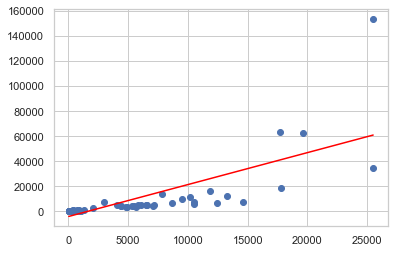

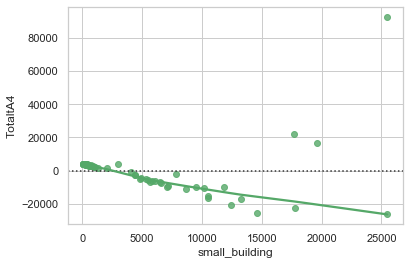

In [257]:
xp = (all_x_sams.multi_appartment_building.drop(labels=[1280,1281,1283,1290,1292, 1293]))
yp = all_y_att.TotaltA4.drop(labels=[1280,1281,1283,1290,1292, 1293])
# xp = all_x_sams.small_building
# yp = all_y_att.TotaltA4

fig, ax = plt.subplots()

ax.scatter(xp, yp)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax.plot(np.unique(xp), np.poly1d(np.polyfit(xp, yp, 1))(np.unique(xp)), color='red')

ax.plot()

fig, ax = plt.subplots()
sns.set(style="whitegrid")

# Plot the residuals after fitting a linear model
sns.residplot(xp, yp, lowess=True, color="g")

# Gravity model for SAMS

# Gravity

In [288]:
sams_distance_matrix = pd.read_csv('data/sams_distance_matrix.csv', sep=';', index_col=[0])
sams_distance_matrix.columns = sams_distance_matrix.index
#the thing above is differently sorted
sams_distance_matrix = sams_distance_matrix.sort_index().T.sort_index().T

In [289]:
sams_distance_matrix.replace(0, np.nan, inplace=True)
for (idx, value) in sams_distance_matrix.min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = value * (2.0 / 3)
sams_distance_matrix.at[12650001, 12650002] = sams_distance_matrix.loc[12650001].min() * (1.0 / 2)
sams_distance_matrix.at[12650002, 12650001] = sams_distance_matrix.loc[12650002].min() * (1.0 / 2)
sams_distance_matrix.at[12700020, 12700001] = sams_distance_matrix.loc[12700020].min() * (1.0 / 2)
sams_distance_matrix.at[12700001, 12700020] = sams_distance_matrix.loc[12700001].min() * (1.0 / 2)

In [290]:
pred_prod_sams = pd.DataFrame(production_model.predict(scaler_att.transform(all_x_sams.loc[:, x_prod.columns])), index=all_x_sams.index, columns=['predicted_production']).sort_index()
pred_attr_sams = pd.DataFrame(attraction_model.predict(scaler_att.transform(all_x_sams.loc[:, x_att.columns])), index=all_x_sams.index, columns=['predicted_attraction']).sort_index()

# pred_attr_sams_b = pred_attr_sams * (pred_prod_sams.sum().values / pred_attr_sams.sum().values)

### Mean trip length from RVU

In [291]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
resfil_raw = resfil_raw[resfil_raw['ärende_2'] == 1]

rvu_mtl = resfil_raw['rf7_km'].mean() * 1000
print(rvu_mtl)

19718.22845453004


In [292]:
f = sams_distance_matrix.values
cost_matrix = np.exp(-8.210386390939112e-05*(f))
Trips1 = fratar_double_constrained(prodA = pred_prod_sams.values.flatten(),
                                   attrA = pred_attr_sams.values.flatten(), 
                                   cost_matrix = cost_matrix,
                                    num_iter=100)

Checking production, attraction balancing:
Production:  590363.5965259195
Attraction:  335016.76980787306
Productions and attractions do not balance, attractions will be scaled to productions!


In [341]:
prodA = pred_prod_sams.values.flatten()
attrA = pred_attr_sams.values.flatten()
f = sams_distance_matrix.values
c=-0.00001
c2 = 0.000000005
cost_matrix = np.power(f, c2) * np.exp(c*f)
num_iter=10
num_iter_cal = 500
mtl = rvu_mtl
num_zones = len(prodA)
alpha = 0.1
f = f

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix
#Run 2D balancing --->
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
trips = trips.round(0)

for Iter in range(0, num_iter_cal):

    model_trip_len = (trips * f).sum() / trips.sum()
    c = c*(model_trip_len / mtl)**alpha
    cost_matrix = np.power(f, c2) * np.exp(c * f)
    for _ in range(0, num_iter):
        trips = cost_matrix
        #Run 2D balancing --->
        computed_attractions = trips.sum(0)
        computed_attractions[computed_attractions==0]=1
        trips = trips * (attrT / computed_attractions)
        trips = trips.round(0)

        computed_productions = trips.sum(1)
        computed_productions[computed_productions==0]=1
        trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
        trips = trips.round(0)
    print ('iteration: ', Iter, ' coefficient: ', c, ' average trip length (model): ', model_trip_len)

print ('target average trip length (observed): ', mtl) 
print ('final average trip length (model): ', model_trip_len)
print ('final logit scaling factor: ', c)

Checking production, attraction balancing:
Production:  590363.5965259195
Attraction:  335016.76980787306
Productions and attractions do not balance, attractions will be scaled to productions!
iteration:  0  coefficient:  -1.110656956800542e-05  average trip length (model):  56320.604347503664
iteration:  1  coefficient:  -1.2310205801791982e-05  average trip length (model):  55172.36705941532
iteration:  2  coefficient:  -1.3613346451106114e-05  average trip length (model):  53934.136584492364
iteration:  3  coefficient:  -1.5016766195605309e-05  average trip length (model):  52599.68128728664
iteration:  4  coefficient:  -1.651946950435018e-05  average trip length (model):  51175.8033770983
iteration:  5  coefficient:  -1.8119057194573463e-05  average trip length (model):  49689.30099732443
iteration:  6  coefficient:  -1.981028814584469e-05  average trip length (model):  48130.443139000476
iteration:  7  coefficient:  -2.1586699804511343e-05  average trip length (model):  46539.5831

iteration:  118  coefficient:  -8.184180402744745e-05  average trip length (model):  19730.579455220104
iteration:  119  coefficient:  -8.184672332706552e-05  average trip length (model):  19730.083779069693
iteration:  120  coefficient:  -8.185130985038348e-05  average trip length (model):  19729.280934113798
iteration:  121  coefficient:  -8.185534607396908e-05  average trip length (model):  19727.953997323708
iteration:  122  coefficient:  -8.18591704302586e-05  average trip length (model):  19727.442927500975
iteration:  123  coefficient:  -8.18626916895105e-05  average trip length (model):  19726.71210222114
iteration:  124  coefficient:  -8.186596425055873e-05  average trip length (model):  19726.11247527505
iteration:  125  coefficient:  -8.186887509025885e-05  average trip length (model):  19725.24062218864
iteration:  126  coefficient:  -8.187165391069696e-05  average trip length (model):  19724.9223032122
iteration:  127  coefficient:  -8.187416290710885e-05  average trip len

iteration:  230  coefficient:  -8.190869322205549e-05  average trip length (model):  19718.230884881137
iteration:  231  coefficient:  -8.190869423161308e-05  average trip length (model):  19718.230884881137
iteration:  232  coefficient:  -8.190869524117068e-05  average trip length (model):  19718.230884881137
iteration:  233  coefficient:  -8.19086962507283e-05  average trip length (model):  19718.230884881137
iteration:  234  coefficient:  -8.190869726028593e-05  average trip length (model):  19718.230884881137
iteration:  235  coefficient:  -8.190869826984357e-05  average trip length (model):  19718.230884881137
iteration:  236  coefficient:  -8.190869927940123e-05  average trip length (model):  19718.230884881137
iteration:  237  coefficient:  -8.19087002889589e-05  average trip length (model):  19718.230884881137
iteration:  238  coefficient:  -8.190870129851659e-05  average trip length (model):  19718.230884881137
iteration:  239  coefficient:  -8.190870230807427e-05  average tri

iteration:  354  coefficient:  -8.19088184072918e-05  average trip length (model):  19718.230884881137
iteration:  355  coefficient:  -8.190881941685093e-05  average trip length (model):  19718.230884881137
iteration:  356  coefficient:  -8.190881557250633e-05  average trip length (model):  19718.2191998918
iteration:  357  coefficient:  -8.190881658206542e-05  average trip length (model):  19718.230884881137
iteration:  358  coefficient:  -8.190881759162453e-05  average trip length (model):  19718.230884881137
iteration:  359  coefficient:  -8.190881860118365e-05  average trip length (model):  19718.230884881137
iteration:  360  coefficient:  -8.190881961074279e-05  average trip length (model):  19718.230884881137
iteration:  361  coefficient:  -8.190881576639817e-05  average trip length (model):  19718.2191998918
iteration:  362  coefficient:  -8.190881677595728e-05  average trip length (model):  19718.230884881137
iteration:  363  coefficient:  -8.190881778551639e-05  average trip l

iteration:  482  coefficient:  -8.190881657545831e-05  average trip length (model):  19718.230884881137
iteration:  483  coefficient:  -8.190881758501742e-05  average trip length (model):  19718.230884881137
iteration:  484  coefficient:  -8.190881859457654e-05  average trip length (model):  19718.230884881137
iteration:  485  coefficient:  -8.190881960413567e-05  average trip length (model):  19718.230884881137
iteration:  486  coefficient:  -8.190881575979106e-05  average trip length (model):  19718.2191998918
iteration:  487  coefficient:  -8.190881676935017e-05  average trip length (model):  19718.230884881137
iteration:  488  coefficient:  -8.190881777890928e-05  average trip length (model):  19718.230884881137
iteration:  489  coefficient:  -8.19088187884684e-05  average trip length (model):  19718.230884881137
iteration:  490  coefficient:  -8.190881494412382e-05  average trip length (model):  19718.2191998918
iteration:  491  coefficient:  -8.190881595368292e-05  average trip l

In [342]:
# trips = pd.DataFrame(Trips1, columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
# trips.head()
trips = pd.DataFrame(trips.astype(int), columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
trips.head()

,1214,1230,1231,1233,1256,1257,1260,1261,1262,1263,...,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020
1214,982,16,24,15,3,6,188,610,111,8,...,0,0,0,0,0,0,0,0,0,0
1230,17,820,560,485,1,0,2,205,313,245,...,0,0,0,0,0,0,0,0,0,0
1231,15,342,390,307,0,0,2,182,279,155,...,0,0,0,0,0,0,0,0,0,0
1233,6,214,199,5228,0,0,1,73,111,300,...,0,0,0,0,0,0,0,0,0,0
1256,0,0,0,0,1091,19,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [343]:
(trips*f).sum().sum() / trips.sum().sum()

19718.219199891795

In [344]:
trips.sum().sum()

590246

In [345]:
pred_prod_sams.sum()

predicted_production    590363.596526
dtype: float64

### All trips after gravity vs predicted attraction / production

In [365]:
trips.loc[12650001:12659999, 1280].sum().sum()

1188

In [354]:
trips.loc[:, 12650001:12659999].sum().sum()

2599

In [358]:
trips.loc[12650001:12659999, 12650001:12659999].sum().sum()

1206

In [359]:
trips.loc[:, 12700001:12709999].sum().sum()

1771

In [360]:
trips.loc[12700001:12709999, 12700001:12709999].sum().sum()

959

In [361]:
pred_attr_sams.loc[12650001:12659999].sum()

predicted_attraction    6076.818847
dtype: float64

In [366]:
y_att

KOMMUN
1214     3315.0
1230     5433.0
1231     7766.0
1233     7733.0
1256     3928.0
1257     3585.0
1260     4402.0
1261     6946.0
1262     5087.0
1263     4762.0
1264     3590.0
1266     4973.0
1267     4312.0
1272     4244.0
1273     4189.0
1275     2914.0
1276     5084.0
1277     5341.0
1278     6045.0
1282    13589.0
1284     7408.0
1285    10103.0
1286    11301.0
1287    12314.0
1291     6712.0
Name: TotaltA4, dtype: float64

In [362]:
trips.loc[12650001:12659999, :].sum().sum()

8974

In [363]:
pred_prod_sams.loc[12650001:12659999].sum()

predicted_production    9014.80897
dtype: float64

In [364]:
trips.loc[1280, :].sum()

152270

In [351]:
pred_prod_sams.loc[1280].sum()

152271.64479853172

In [352]:
trips.loc[:, 1280].sum()

161667

In [353]:
pred_attr_sams.loc[1280].sum()

59409.901863245155

### All trips within Sjöbo

In [235]:
trips.loc[12650001:12659999, 12650001:12659999].sum().sum()

532

### Testing stuff Fratar with and without mean trip length adjustments (but not really)

In [177]:
trips = pd.DataFrame(trips, columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
trips.head()

,1214,1230,1231,1233,1256,1257,1260,1261,1262,1263,...,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020
1214,1019.285439,22.706772,25.505472,8.707495,0.426708,1.803812,125.387297,695.856038,104.337894,8.518713,...,0.002258,0.000897,-0.005382,-0.000904,-0.006108,0.012009,-0.000522,-0.000201,-0.000276,-0.001185
1230,11.492826,766.658626,405.714804,193.021291,0.072208,0.134482,0.909113,157.057692,198.412104,188.836531,...,0.025146,0.009987,-0.008089,-0.010072,-0.015338,0.054421,-0.005809,-0.004456,-0.006112,-0.013199
1231,10.374313,322.704729,285.801319,123.749412,0.030945,0.121394,0.820635,141.772411,179.102100,121.066488,...,0.006834,0.002714,-0.002198,-0.002737,-0.004168,0.014789,-0.001058,-0.002857,-0.003919,-0.002395
1233,5.815927,283.812688,205.311350,2987.983312,0.018843,0.068054,0.460055,79.478803,100.406139,330.619248,...,0.006138,0.002438,-0.001933,-0.002407,-0.003666,0.013007,-0.002888,-0.007802,-0.010702,-0.006540
1256,1.249080,1.371307,0.721141,0.246969,846.018656,32.201731,4.140491,1.392382,1.118366,0.241615,...,0.027717,0.009137,-0.079318,-0.033894,-0.071878,1.008225,-0.005315,-0.005195,-0.007049,-0.009356


In [178]:
trips.loc[12650000:12659999, 12650000:12659999].sum().sum()

1674.9069312060233

In [179]:
trips.loc[12650000:12659999, :].sum().sum()

8613.448997793937

In [163]:
pd.concat([sams_distance_matrix.loc[1280], trips.loc[1280]], axis=1)

,1280,1280
1214,59281.024,95.478868
1230,17367.971,2996.925648
1231,10265.369,3512.843571
1233,24280.615,4320.486067
1256,114968.564,0.310372
...,...,...
12700016,90744.224,0.137345
12700017,84048.485,-0.018152
12700018,77347.315,-0.049037
12700019,71831.810,-0.067262


In [172]:
trips.loc[12650008].astype(int)

1214         0
1230        19
1231         6
1233         3
1256         0
            ..
12700016     0
12700017     0
12700018     0
12700019     0
12700020     0
Name: 12650008, Length: 68, dtype: int64